<a href="https://colab.research.google.com/github/Zerldas/Translate-EN-to-FR-Project/blob/main/NLP_Project_Translate_EN_to_FR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!python3 --version

Python 3.12.12


**Kiểm tra và tải về các thư viện cần thiết trước khi thực hiện project**

In [4]:
# Tải về các thư viện cần thiết trước khi thực hiện project
!pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.12.0
anywidget                           

In [5]:
!pip install spacy

!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 110.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 95.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


***Danh sách các thư viện sẽ được sử dụng***

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import random
import time
import torch.nn.functional as F
from datetime import datetime
from wordcloud import WordCloud
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

Thiết lập GPU

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

Device: cpu


Thiết lại tokenizer

In [8]:
tokenize_en = spacy.load("en_core_web_sm")
tokenize_fr = spacy.load("fr_core_news_sm")

In [9]:
def tokenizer_en(sentence):
  return [token.text.lower()
          for token in tokenize_en(sentence)
          if token.text.strip()]

def tokenizer_fr(sentence):
  return [token.text.lower()
          for token in tokenize_fr(sentence)
          if token.text.strip()]

***Tiến hành phân tích dữ liệu***

In [10]:
# Khai báo dường đẫn dữ liệu train
train_en_path = "/content/drive/MyDrive/EN-FR/data/train/train.en"
train_fr_path = "/content/drive/MyDrive/EN-FR/data/train/train.fr"
# Dữ liệu valiation
val_en_path = "/content/drive/MyDrive/EN-FR/data/val/val.en"
val_fr_path = "/content/drive/MyDrive/EN-FR/data/val/val.fr"
# Dữ liệu test sử dụng tạp test 2016 flick
test_en_path = "/content/drive/MyDrive/EN-FR/data/test/test_2016_flickr.en"
test_fr_path = "/content/drive/MyDrive/EN-FR/data/test/test_2016_flickr.fr"

In [11]:
def load_data(en_path, fr_path):
  with open(en_path, encoding="utf-8") as f_en:
    en_lines = [line.strip() for line in f_en]

  with open(fr_path, encoding="utf-8") as f_fr:
    fr_lines = [line.strip() for line in f_fr]

  assert len(en_lines) == len(fr_lines), "EN-FR line count mismatch!"
  return en_lines, fr_lines

In [12]:
train_en_lines, train_fr_lines = load_data(train_en_path, train_fr_path)
val_en_lines, val_fr_lines = load_data(val_en_path, val_fr_path)
test_en_lines, test_fr_lines = load_data(test_en_path, test_fr_path)

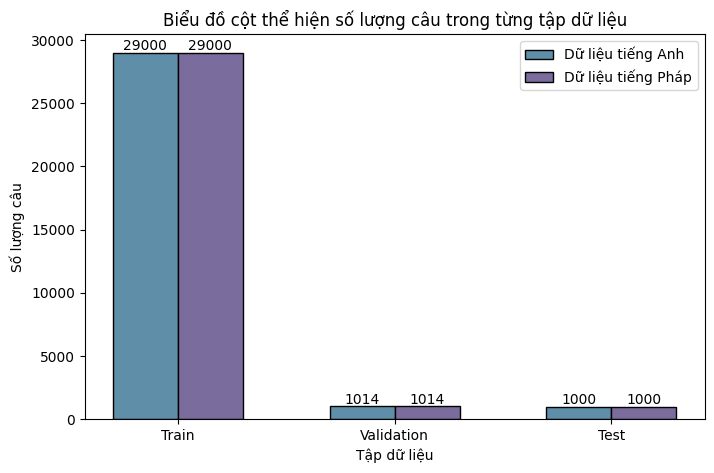

In [33]:
labels = ["Train", "Validation", "Test"]
en_counts = [
  len(train_en_lines),
  len(val_en_lines),
  len(test_en_lines)
]
fr_counts = [
  len(train_fr_lines),
  len(val_fr_lines),
  len(test_fr_lines)
]
width = 0.3
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8,5))

bars_en = ax.bar(x - width/2, en_counts, width, label='Dữ liệu tiếng Anh', color='#5F8FA8', linewidth=1, edgecolor='black')
bars_fr = ax.bar(x + width/2, fr_counts, width, label='Dữ liệu tiếng Pháp', color='#7A6C9D', linewidth=1, edgecolor='black')

ax.set_xlabel("Tập dữ liệu")
ax.set_ylabel("Số lượng câu")
ax.set_title("Biểu đồ cột thể hiện số lượng câu trong từng tập dữ liệu")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      height,
      f"{int(height)}",
      ha="center",
      va="bottom"
    )

add_labels(bars_en)
add_labels(bars_fr)

plt.show()

In [16]:
# Xem xét độ dài câu (token)
def get_lengths(sentences, tokenizer):
  return [len(tokenizer(s)) for s in sentences]

train_len_en = get_lengths(train_en_lines, tokenizer_en)
train_len_fr = get_lengths(train_fr_lines, tokenizer_fr)
val_len_en = get_lengths(val_en_lines, tokenizer_en)
val_len_fr = get_lengths(val_fr_lines, tokenizer_fr)
test_len_en = get_lengths(test_en_lines, tokenizer_en)
test_len_fr = get_lengths(test_fr_lines, tokenizer_fr)

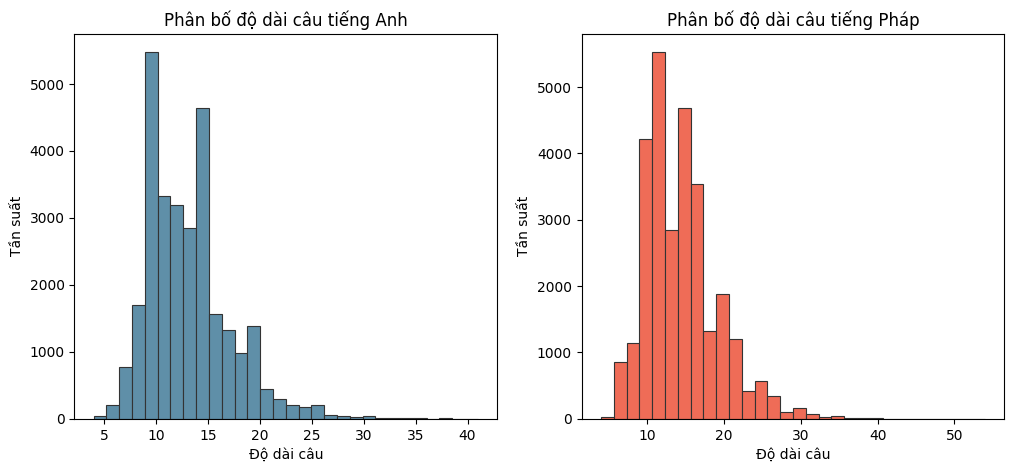

In [36]:
# Biểu đồ xem xét độ dài câu trong tập train
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(train_len_en, bins=30, color="#5F8FA8", edgecolor="#333333", linewidth=0.8)
plt.xlabel("Độ dài câu")
plt.ylabel("Số lượng câu")
plt.title("Phân bố độ dài câu tiếng Anh")

plt.subplot(1,2,2)
plt.hist(train_len_fr, bins=30, color="#EF6C57", edgecolor="#333333", linewidth=0.8)
plt.xlabel("Độ dài câu")
plt.ylabel("Số lượng câu")
plt.title("Phân bố độ dài câu tiếng Pháp")

plt.show()

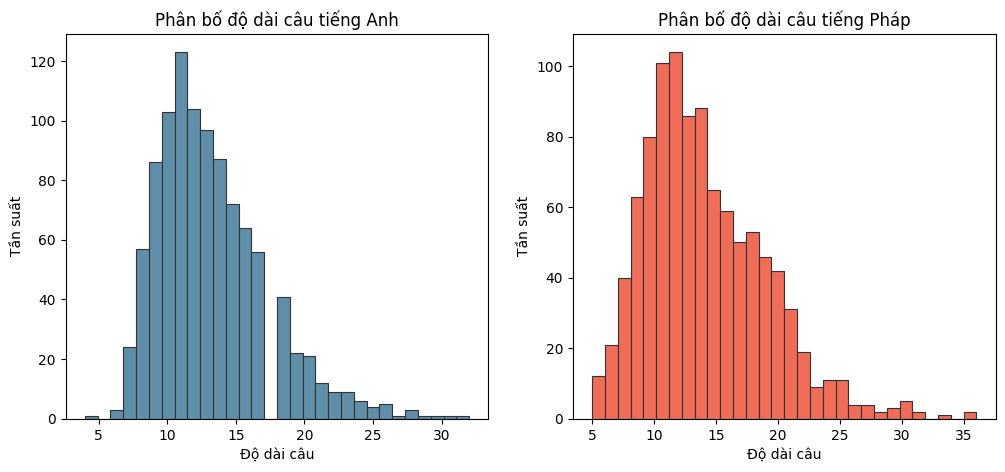

In [37]:
# Biểu đồ xem xét độ dài câu trong tập valid
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(val_len_en, bins=30, color="#5F8FA8", edgecolor="#333333", linewidth=0.8)
plt.xlabel("Độ dài câu")
plt.ylabel("Số lượng câu")
plt.title("Phân bố độ dài câu tiếng Anh")

plt.subplot(1,2,2)
plt.hist(val_len_fr, bins=30, color="#EF6C57", edgecolor="#333333", linewidth=0.8)
plt.xlabel("Độ dài câu")
plt.ylabel("Số lượng câu")
plt.title("Phân bố độ dài câu tiếng Pháp")

plt.show()

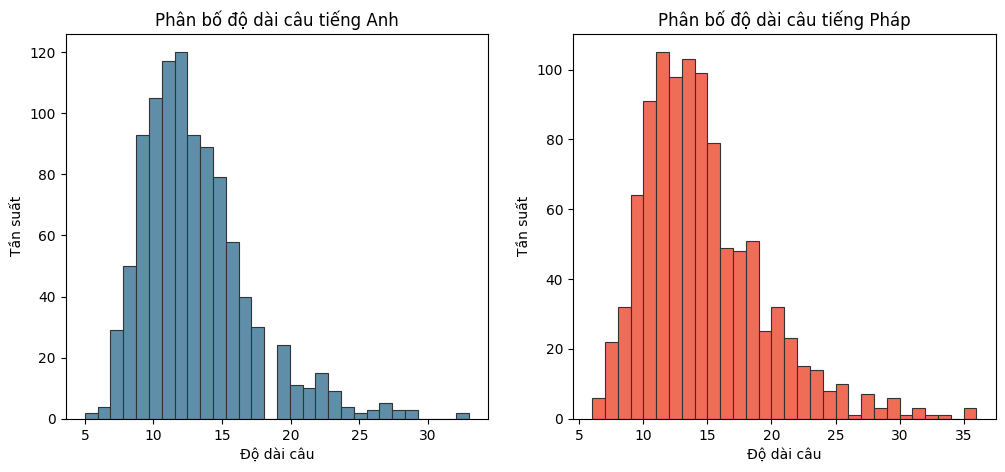

In [39]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(test_len_en, bins=30, color="#5F8FA8", edgecolor="#333333", linewidth=0.8)
plt.xlabel("Độ dài câu")
plt.ylabel("Số lượng câu")
plt.title("Phân bố độ dài câu tiếng Anh")

plt.subplot(1,2,2)
plt.hist(test_len_fr, bins=30, color="#EF6C57", edgecolor="#333333", linewidth=0.8)
plt.xlabel("Độ dài câu")
plt.ylabel("Số lượng câu")
plt.title("Phân bố độ dài câu tiếng Pháp")

plt.show()

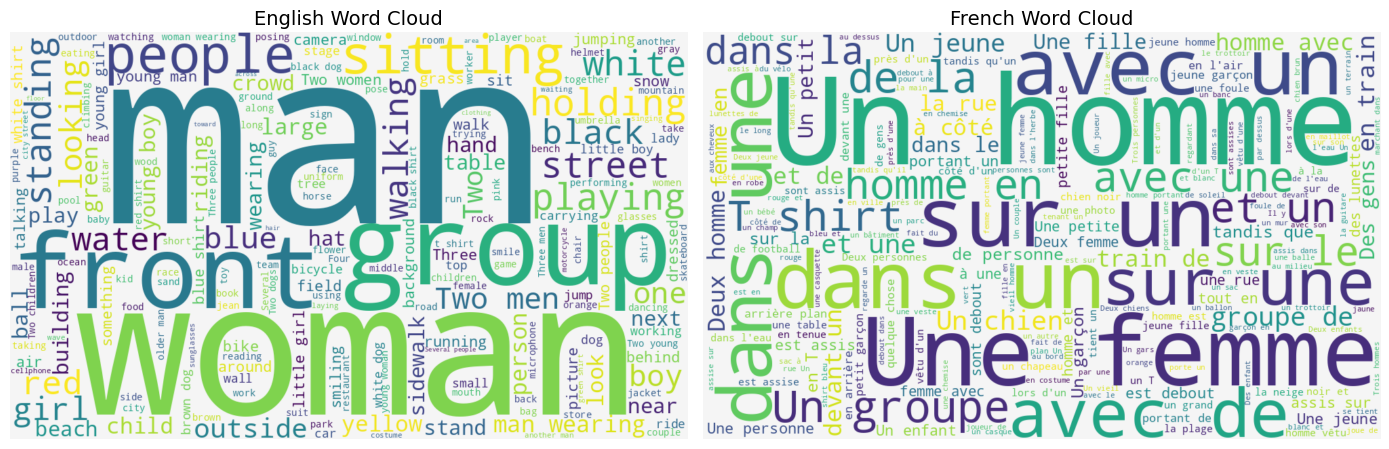

In [44]:
en_text = " ".join(train_en_lines)
fr_text = " ".join(train_fr_lines)

wordcloud_en = WordCloud(width=1000, height=600, background_color='#F5F5F5').generate(en_text)
wordcloud_fr = WordCloud(width=1000, height=600, background_color='#F5F5F5').generate(fr_text)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(wordcloud_en, interpolation="bilinear")
plt.axis("off")
plt.title("English Word Cloud", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(wordcloud_fr, interpolation="bilinear")
plt.axis("off")
plt.title("French Word Cloud", fontsize=14)

# Đường kẻ phân cách giữa 2 biểu đồ
fig.lines.append(
  plt.Line2D(
    [0.5, 0.5],   # x start, x end (giữa figure)
    [0.1, 0.9],   # y start, y end
    transform=fig.transFigure,
    color="#CCCCCC",
    linewidth=1
  )
)

plt.tight_layout()
plt.show()

Xây dựng vocabulary

In [45]:
index_token = [
  "<pad>", #Padding giúp câu có cùng độ dài
  "<unk>", #Unknow đánh dấu từ không có nghĩa
  "<sos>", #Từ ở đầu câu
  "<eos>"  #TỪ ở cuối câu
]

PAD_IDX = index_token.index("<pad>")   # 0
UNK_IDX = index_token.index("<unk>")   # 1
SOS_IDX = index_token.index("<sos>")   # 2
EOS_IDX = index_token.index("<eos>")   # 3

In [46]:
def build_vocab(sentences, tokenizer, max_size):
  counter = Counter()

  for sen in sentences:
    tokens = tokenizer(sen)
    counter.update(tokens)

  most_common = counter.most_common(max_size - 4)
  # Danh sách từ
  idx_token = index_token + [word for word, _ in most_common]
  # map token → id
  token_to_index = {token: idx for idx, token in enumerate(idx_token)}

  return token_to_index, idx_token, counter

In [47]:
# Build vocab
vocab_en, index_en, counter_en = build_vocab(train_en_lines, tokenizer_en, max_size=8000)
vocab_fr, index_fr, counter_fr = build_vocab(train_fr_lines, tokenizer_fr, max_size=8000)

print("EN vocab size:", len(vocab_en))
print("FR vocab size:", len(vocab_fr))

EN vocab size: 8000
FR vocab size: 8000


In [48]:
# Đưa vocab về dạng số
def numericalize_source(sentence, tokenizer, vocab):
  tokens = tokenizer(sentence)

  if len(tokens) == 0:
    tokens = ["<unk>"]   # bảo vệ câu rỗng

  tokens = tokens + ["<eos>"]

  return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

def numericalize_target(sentence, tokenizer, vocab):
  tokens = ["<sos>"] + tokenizer(sentence) + ["<eos>"]
  return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

In [49]:
class Translate_Dataset(torch.utils.data.Dataset):
  def __init__(self, en_sentences, fr_sentences,
                tokenizer_en, tokenizer_fr,
                vocab_en, vocab_fr):

    assert len(en_sentences) == len(fr_sentences)

    self.en_sentences = en_sentences
    self.fr_sentences = fr_sentences
    self.tokenizer_en = tokenizer_en
    self.tokenizer_fr = tokenizer_fr
    self.vocab_en = vocab_en
    self.vocab_fr = vocab_fr

  def __len__(self):
    return len(self.en_sentences)

  def __getitem__(self, index):
    source_ids = numericalize_source(
      self.en_sentences[index],
      self.tokenizer_en,
      self.vocab_en
    )

    target_ids = numericalize_target(
      self.fr_sentences[index],
      self.tokenizer_fr,
      self.vocab_fr
    )

    # length dùng cho pack_padded_sequence
    source_lengths = len(source_ids)

    return (
      torch.tensor(source_ids, dtype=torch.long),
      torch.tensor(target_ids, dtype=torch.long),
      source_lengths
    )

In [50]:
SOURCE_PAD_IDX = vocab_en["<pad>"]
TARGET_PAD_IDX = vocab_fr["<pad>"]

def collate_fn(batch):
  source_batch, target_batch, source_lengths = zip(*batch)
  source_lengths = torch.tensor(source_lengths)
  source_lengths, sorted_idx = source_lengths.sort(descending=True)

  source_batch = [source_batch[i] for i in sorted_idx]
  target_batch = [target_batch[i] for i in sorted_idx]

  source_batch = pad_sequence(
    source_batch,
    batch_first=True,
    padding_value=SOURCE_PAD_IDX
  )

  target_batch = pad_sequence(
    target_batch,
    batch_first=True,
    padding_value=TARGET_PAD_IDX
  )

  assert source_lengths.min() > 0, "Found source length <= 0"

  return source_batch, target_batch, source_lengths

In [51]:
# Tạo DataLoaders
train = Translate_Dataset(train_en_lines, train_fr_lines, tokenizer_en, tokenizer_fr, vocab_en, vocab_fr)
val = Translate_Dataset(val_en_lines, val_fr_lines, tokenizer_en, tokenizer_fr, vocab_en, vocab_fr)
test = Translate_Dataset(test_en_lines, test_fr_lines, tokenizer_en, tokenizer_fr, vocab_en, vocab_fr)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size=32 ,shuffle=False, collate_fn=collate_fn)

Encoder

In [52]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(dropout)
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(
      embed_size,
      hidden_size,
      num_layers=num_layers,
      dropout=dropout if num_layers > 1 else 0,
      batch_first=True,
    )

  def forward(self, source, lengths):
    if isinstance(lengths, list):
      lengths = torch.tensor(lengths, dtype=torch.long, device=source.device)

    lengths = lengths.cpu()

    embedded = self.dropout(self.embedding(source))

    packed = nn.utils.rnn.pack_padded_sequence(
      embedded,
      lengths,
      batch_first=True,
      enforce_sorted=True
    )

    packed_outputs, (hidden, cell) = self.lstm(packed)

    outputs, _ = nn.utils.rnn.pad_packed_sequence(
        packed_outputs, batch_first=True
    )

    return outputs, (hidden, cell)

Decoder

In [53]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, pad_idx):
    super().__init__()

    self.embedding = nn.Embedding(
      vocab_size,
      embed_size,
      padding_idx=pad_idx
    )

    self.lstm = nn.LSTM(
      embed_size,
      hidden_size,
      num_layers=num_layers,
      dropout=dropout if num_layers > 1 else 0.0,
      batch_first=True
    )

    self.fc_out = nn.Linear(hidden_size, vocab_size)

  def forward(self, token, hidden, cell):
    token = token.unsqueeze(1)
    embedded = self.embedding(token)
    output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
    prediction = self.fc_out(output.squeeze(1))

    return prediction, hidden, cell

Seq2Seq

In [54]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, pad_index):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.pad_index = pad_index

  def forward(self, source, target, source_lengths, teacher_forcing_ratio=0.01):
    batch_size, target_sequence_length = target.size()
    vocabulary_size = self.decoder.fc_out.out_features
    device = source.device

    outputs = torch.zeros(batch_size, target_sequence_length, vocabulary_size, device=device)

    encoder_outputs, (hidden_state, cell_state) = self.encoder(source, source_lengths)

    decoder_input = target[:, 0]

    for timestep in range(1, target_sequence_length):

      decoder_output, hidden_state, cell_state = self.decoder(
        decoder_input, hidden_state, cell_state
      )

      outputs[:, timestep] = decoder_output
      use_teacher_forcing = random.random() < teacher_forcing_ratio
      predicted_token = decoder_output.argmax(1)
      decoder_input = target[:, timestep] if use_teacher_forcing else predicted_token

    return outputs

Build Model

In [55]:
# Khai báo thông số model
INPUT_SIZE = len(vocab_en)
OUTPUT_SIZE = len(vocab_fr)
ENC_EMB_SIZE = 256
DEC_EMB_SIZE = 256
HID_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.5
BATCH_SIZE = 32
N_EPOCHS = 20
LEARNING_RATE = 0.001

In [56]:
#  Thiết lập Early Stopping
class EarlyStopping:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.best_loss = float('inf')
    self.counter = 0
    self.should_stop = False

  def __call__(self, val_loss):
    # Nếu cải thiện
    if val_loss < self.best_loss - self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      print(f"No improvement ({self.counter}/{self.patience})")

      if self.counter >= self.patience:
        self.should_stop = True
        print("\n Early Stopping Triggered!")

In [57]:
encoder = Encoder(INPUT_SIZE, ENC_EMB_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
decoder = Decoder(OUTPUT_SIZE, DEC_EMB_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT, PAD_IDX).to(DEVICE)
model = Seq2Seq(encoder, decoder, PAD_IDX).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer,
  mode='min',
  factor=0.5,
  patience=2,
  threshold=1e-4,
  cooldown=0,
  min_lr=1e-6,
)

Training Loop

In [58]:
def train_epoch(model):
  model.train()
  total_loss = 0

  for source, target, source_lengths in train_loader:
    source = source.to(DEVICE)
    target = target.to(DEVICE)

    optimizer.zero_grad()

    output = model(source, target, source_lengths)

    # Bỏ <sos> trong cả output và target
    output = output[:, 1:].contiguous().view(-1, output.size(-1))
    target = target[:, 1:].contiguous().view(-1)

    loss = criterion(output, target)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(train_loader)

In [59]:
# Tính Valid
def eval_epoch(model):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for source, target, source_lengths in val_loader:
      source = source.to(DEVICE)
      target = target.to(DEVICE)

      output = model(
        source,
        target,
        source_lengths,
        teacher_forcing_ratio=0.1
      )

      output = output[:, 1:].contiguous().view(-1, output.size(-1))
      target = target[:, 1:].contiguous().view(-1)

      loss = criterion(output, target)
      total_loss += loss.item()

  return total_loss / len(val_loader)

In [60]:
# Hàm train model
def train_model(
  model,
  train_epoch,
  eval_epoch,
  scheduler,
  early_stopping,
  n_epochs,
  save_path="best_model_without_attention.pth"
):
  train_losses = []
  val_losses = []

  for epoch in range(n_epochs):
    start_time = time.time()

    train_loss = train_epoch(model)
    val_loss = eval_epoch(model)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Scheduler theo validation loss
    scheduler.step(val_loss)

    # Tính thời gian
    end_time = time.time()
    elapsed = end_time - start_time
    minutes = int(elapsed // 60)
    seconds = int(elapsed % 60)

    # Logging
    print("\n" + "=" * 50)
    print(f"EPOCH {epoch + 1}/{n_epochs} — time: {minutes}:{seconds:02d}")
    print("-" * 50)
    print(f"   Train Loss : {train_loss:.4f}")
    print(f"   Val Loss   : {val_loss:.4f}")
    print("=" * 50)

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"\nEARLY STOPPING AT EPOCH {epoch + 1}")
        break

  # Lưu model sau khi train
  torch.save(model.state_dict(), save_path)

  return train_losses, val_losses

In [61]:
early_stopping = EarlyStopping(patience=3, min_delta=1e-4)

In [62]:
# Train model
train_losses, val_losses = train_model(
  model=model,
  train_epoch=train_epoch,
  eval_epoch=eval_epoch,
  scheduler=scheduler,
  early_stopping=early_stopping,
  n_epochs=N_EPOCHS,
  save_path="best_model_without_attention.pth"
)

KeyboardInterrupt: 

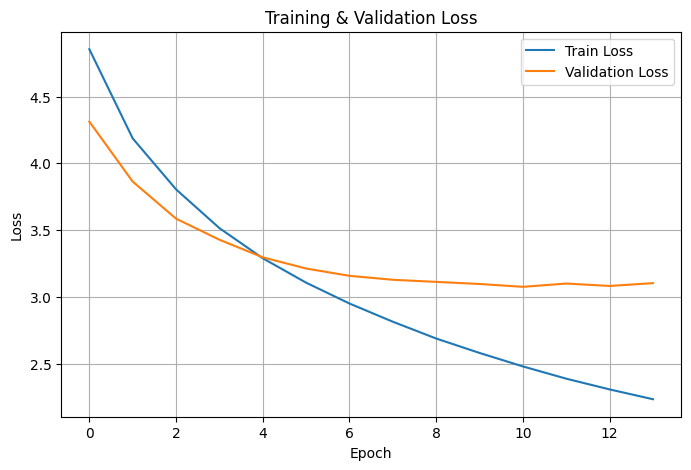

In [ ]:
def plot_losses(train_losses, val_losses):
  plt.figure(figsize=(8, 5))
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training & Validation Loss")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_losses(train_losses, val_losses)

In [ ]:
# Hàm translate
def translate(sentence, model):
  model.eval()
  source_ids = numericalize_source(sentence, tokenizer_en, vocab_en)
  source_tensor = torch.tensor(source_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
  source_lengths = torch.tensor(
    [source_tensor.size(1)],
    dtype=torch.int64
  ).cpu()
  idx_to_fr = [token for token, idx in sorted(vocab_fr.items(), key=lambda x: x[1])]

  with torch.no_grad():
    encoder_outputs, (hidden, cell) = model.encoder(source_tensor, source_lengths)
    token = torch.tensor([SOS_IDX], dtype=torch.long, device=DEVICE)

    result_tokens = []

    for _ in range(50):
      output, hidden, cell = model.decoder(token, hidden, cell)

      next_token = output.argmax(1)
      idx = next_token.item()

      if idx == EOS_IDX:
        break

      result_tokens.append(idx_to_fr[idx])
      token = next_token

  return " ".join(result_tokens)

In [ ]:
# Hàm tính BLEU
def compute_bleu(n, model, translate_method):
  smoothie = SmoothingFunction().method4
  scores = []

  for i in range(n):
    pred_sentence = translate_method(test_en_lines[i], model).lower()
    pred_tokens = pred_sentence.split()

    ref_tokens = tokenizer_fr(test_fr_lines[i].lower())

    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    scores.append(bleu)

  return sum(scores) / len(scores)

print("BLEU:", compute_bleu(100, model, translate))

TypeError: Decoder.forward() takes 4 positional arguments but 6 were given

In [ ]:
# Dịch thử năm câu
for i in range(5):
    print("\nLần dịch thứ" + str(i + 1))
    print("=" * 50)

    print("Câu tiếng Anh gốc:")
    print(test_en_lines[i])

    print("\nCâu dự đoán do mô hình dịch:")
    print(translate(test_en_lines[i], model))

    print("\nCâu tiếng Pháp(đúng):")
    print(test_fr_lines[i])

    print("\n" + "=" * 50)


Lần dịch thứ1
Câu tiếng Anh gốc:
A man in an orange hat starring at something.

Câu dự đoán do mô hình dịch:
un homme avec un casquette orange quelque quelque chose . .

Câu tiếng Pháp(đúng):
Un homme avec un chapeau orange regardant quelque chose.


Lần dịch thứ2
Câu tiếng Anh gốc:
A Boston Terrier is running on lush green grass in front of a white fence.

Câu dự đoán do mô hình dịch:
un golden de court court sur le herbe verte devant devant un un . .

Câu tiếng Pháp(đúng):
Un terrier de Boston court sur l'herbe verdoyante devant une clôture blanche.


Lần dịch thứ3
Câu tiếng Anh gốc:
A girl in karate uniform breaking a stick with a front kick.

Câu dự đoán do mô hình dịch:
une fille en tenue de de karaté une une un avec avec avec un . . .

Câu tiếng Pháp(đúng):
Une fille en tenue de karaté brisant un bâton avec un coup de pied.


Lần dịch thứ4
Câu tiếng Anh gốc:
Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.

Câu dự đoán do mô h

In [ ]:
!mv best_model_without_attetion.pth ./drive/MyDrive/EN-FR/

mv: cannot stat 'best_model_without_attetion.pth': No such file or directory


Phần Nâng Cao

Thêm Cơ Chế Attention

In [ ]:
class BahdanauAttention(nn.Module):
  def __init__(self, enc_hid_size, dec_hid_size):
    super().__init__()
    self.W_encoder = nn.Linear(enc_hid_size, dec_hid_size)
    self.W_decoder = nn.Linear(dec_hid_size, dec_hid_size)
    self.v = nn.Linear(dec_hid_size, 1, bias=False)

  def forward(self, decoder_hidden, encoder_outputs, mask=None):
    decoder_hidden = decoder_hidden.unsqueeze(1)

    energy = torch.tanh(
        self.W_encoder(encoder_outputs) + self.W_decoder(decoder_hidden)
    )

    score = self.v(energy).squeeze(2)

    if mask is not None:
        score = score.masked_fill(mask == 0, -1e9)

    attn_weights = F.softmax(score, dim=1)

    return attn_weights

In [ ]:
class BahdanauDecoder(nn.Module):
  def __init__(self, output_size, emb_size, enc_hid_size, dec_hid_size, dropout):
    super().__init__()

    self.embedding = nn.Embedding(output_size, emb_size)
    self.dropout = nn.Dropout(dropout)

    self.attention = BahdanauAttention(enc_hid_size, dec_hid_size)

    self.lstm = nn.LSTM(
        emb_size + enc_hid_size,
        dec_hid_size,
        batch_first=True
    )

    self.fc_out = nn.Linear(
        emb_size + enc_hid_size + dec_hid_size,
        output_size
    )

  def forward(self, input_token, hidden, cell, enc_outputs, mask=None):
    embedded = self.dropout(self.embedding(input_token))
    h = hidden[-1]
    attn_weights = self.attention(h, enc_outputs, mask)
    context = torch.bmm(
      attn_weights.unsqueeze(1),
      enc_outputs
    ).squeeze(1)
    rnn_input = torch.cat([embedded, context], dim=1).unsqueeze(1)

    output, (hidden, cell) = self.lstm(
      rnn_input,
      (hidden, cell)
    )

    output = output.squeeze(1)

    logits = self.fc_out(
        torch.cat([output, context, embedded], dim=1)
    )

    return logits, hidden, cell, attn_weights

In [ ]:
class Seq2SeqWithAttention(nn.Module):
  def __init__(self, encoder, decoder, pad_idx):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.pad_idx = pad_idx

  def create_mask(self, src):
    return (src != self.pad_idx)

  def forward(self, source, source_lengths, target, teacher_forcing_ratio=0.2):
    # src: [batch, src_len]
    # trg: [batch, trg_len]
    device = source.device

    if target.dim() == 1:
        target = target.unsqueeze(0)

    batch_size = source.size(0)
    target_len = target.size(1)
    vocab_size = self.decoder.embedding.num_embeddings

    outputs = torch.zeros(
      batch_size,
      target_len,
      vocab_size,
      device=device
    )

    enc_outputs, (hidden, cell) = self.encoder(source, source_lengths)

    # dùng layer cuối của encoder
    hidden = hidden[-1].unsqueeze(0)
    cell = cell[-1].unsqueeze(0)

    input_token = target[:, 0]
    mask = self.create_mask(source)

    for t in range(1, target_len):
      output, hidden, cell, _ = self.decoder(
        input_token, hidden, cell, enc_outputs, mask
      )

      outputs[:, t] = output

      teacher_force = torch.rand(1).item() < teacher_forcing_ratio
      top = output.argmax(1)

      input_token = target[:, t] if teacher_force else top

    return outputs

In [ ]:
encoder = Encoder(INPUT_SIZE, ENC_EMB_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
attention = BahdanauAttention(HID_SIZE, HID_SIZE).to(DEVICE)
decoder = BahdanauDecoder(OUTPUT_SIZE, DEC_EMB_SIZE, HID_SIZE, HID_SIZE, DROPOUT).to(DEVICE)
model_with_attention = Seq2SeqWithAttention(encoder, decoder, PAD_IDX).to(DEVICE)
optimizer = torch.optim.Adam(model_with_attention.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def train_epoch_attention(model):
  model.train()
  total_loss = 0

  for source, target, source_lengths in train_loader:
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_lengths = source_lengths.cpu()

    optimizer.zero_grad()

    output = model(
        source,
        source_lengths,
        target
    )

    output = output[:, 1:].contiguous().view(-1, output.size(-1))
    target = target[:, 1:].contiguous().view(-1)

    loss = criterion(output, target)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(train_loader)

In [ ]:
def eval_epoch_attention(model):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for source, target, source_lengths in val_loader:
      source = source.to(DEVICE)
      target = target.to(DEVICE)
      source_lengths = source_lengths.cpu()

      output = model(
          source,
          source_lengths,
          target,
          teacher_forcing_ratio=0.0
      )

      output = output[:, 1:].contiguous().view(-1, output.size(-1))
      target = target[:, 1:].contiguous().view(-1)

      loss = criterion(output, target)
      total_loss += loss.item()

    return total_loss / len(val_loader)

In [ ]:
# Train model with attention
train_losses_with_attention, val_losses_with_attention = train_model(
    model=model_with_attention,
    train_epoch=train_epoch_attention,
    eval_epoch=eval_epoch_attention,
    scheduler=scheduler,
    early_stopping=early_stopping,
    n_epochs=N_EPOCHS,
    save_path="best_model_with_attention.pth"
)


EPOCH 1/20 — time: 0:13
--------------------------------------------------
   Train Loss : 0.0067
   Val Loss   : 5.8033
No improvement (1/3)

EPOCH 2/20 — time: 0:13
--------------------------------------------------
   Train Loss : 0.0065
   Val Loss   : 5.7375
No improvement (2/3)

EPOCH 3/20 — time: 0:13
--------------------------------------------------
   Train Loss : 0.0064
   Val Loss   : 5.6729
No improvement (3/3)

 Early Stopping Triggered!

EARLY STOPPING AT EPOCH 3


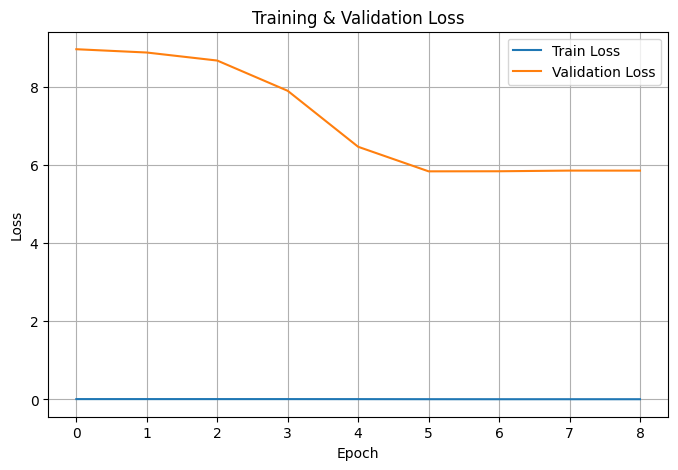

In [ ]:
plot_losses(train_losses_with_attention, val_losses_with_attention)

In [ ]:
def translate_attention(sentence, model, max_len=50):
  model.eval()

  # Numericalize source
  source_ids = numericalize_source(sentence, tokenizer_en, vocab_en)
  source_tensor = torch.tensor(
    source_ids, dtype=torch.long
  ).unsqueeze(0).to(DEVICE)

  source_lengths = torch.tensor(
    [len(source_ids)], dtype=torch.long
  ).cpu()

  idx_to_fr = [token for token, idx in sorted(
    vocab_fr.items(), key=lambda x: x[1]
  )]

  with torch.no_grad():
    # Encoder
    enc_outputs, (hidden, cell) = model.encoder(
      source_tensor, source_lengths
    )

    # Dùng layer cuối của encoder
    hidden = hidden[-1].unsqueeze(0)
    cell = cell[-1].unsqueeze(0)

    # Token bắt đầu
    input_token = torch.tensor(
      [SOS_IDX], dtype=torch.long, device=DEVICE
    )

    result_tokens = []

    # Mask cho attention
    mask = (source_tensor != PAD_IDX)

    for _ in range(max_len):
      output, hidden, cell, _ = model.decoder(
        input_token,
        hidden,
        cell,
        enc_outputs,
        mask
      )

      next_token = output.argmax(1)
      idx = next_token.item()

      if idx == EOS_IDX:
        break

      result_tokens.append(idx_to_fr[idx])
      input_token = next_token

  return " ".join(result_tokens)

In [ ]:
print("BLEU:", compute_bleu(100, model_with_attention, translate_attention))

BLEU: 0.02667959386459121
